In [1]:
import os.path
import re
import sys
import tarfile
import time
import multiprocessing as mp
import itertools

import tensorflow.python.platform
from six.moves import urllib
import numpy as np
import tensorflow as tf
import h5py
import glob
import cPickle as pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.python.platform import gfile

from run_inference import predict_star, predict
import pandas as pd
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def create_graph(pb_file):
    """"Creates a graph from saved GraphDef file and returns a Graph object.
    Returns:
    Graph holding the trained Inception network.
    """
    model_filename = pb_file
    with gfile.FastGFile(model_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        tf.import_graph_def(graph_def, name='')

In [3]:
#create_graph("/data/retrain_manualtags1/output_graphfinal.pb")
create_graph("/data/classify_image_graph_def.pb")
sess = tf.Session()

In [4]:
params = pickle.load(open("/data/datenet_map_outputs/output_params9600.pkl", 'r'))  # use 9600
fw = params["final_weights"]
fb = params["final_biases"]
print fb.shape
print fw.shape

(4,)
(2048, 4)


In [7]:
# I currently don't know what labels correspond to each of the 7 elements; will figure out

In [5]:
# from http://www.socouldanyone.com/2013/03/converting-grayscale-to-rgb-with-numpy.html
def to_rgb(im):
    w, h = im.shape[:2]
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 0] = im
    ret[:, :, 1] = im
    ret[:, :, 2] = im
    return ret

# from http://www.socouldanyone.com/2013/03/converting-grayscale-to-rgb-with-numpy.html
def to_rgbs(im):
    n, w, h = im.shape[:3]
    ret = np.empty((n, w, h, 3), dtype=np.uint8)
    ret[:, :, :, 0] = im[:,:,:,0]
    ret[:, :, :, 1] = im[:,:,:,0]
    ret[:, :, :, 2] = im[:,:,:,0]
    return ret

# from https://gist.github.com/yusugomori/4462221
def softmax(x):
    e = np.exp(x - np.max(x))  # prevent overflow
    if e.ndim == 1:
        return e / np.sum(e, axis=0)
    else:  
        return e / np.array([np.sum(e, axis=1)]).T  # ndim = 2

In [6]:
# read in hdf5 file
image_hdf5 = h5py.File('/data/image_data.hdf5','r')
(image_metadata, book_metadata, image_to_idx) = pickle.load(open("/data/all_metadata_1M_tags.pkl", 'r'))

In [7]:
# get a list of images to look at for each date
date_to_images = {}  # each value is a dictionary with {filename --> idx}
for folder in glob.glob("/data/maps_by_date/*/"):
    era = os.path.basename(folder[:-1])
    imgs = glob.glob(folder + "/*.jpg")
    fns = np.random.choice([os.path.basename(i)[:-4] for i in imgs], 1000, False)
    idxs = [image_to_idx[fn] for fn in fns]
    date_to_images[era] = dict(zip(fns, idxs))
print [(x, len(date_to_images[x].keys())) for x in date_to_images]

[('pre-1850', 1000), ('1870-1889', 1000), ('1850-1869', 1000), ('post-1890', 1000)]


## Pool3 and softmax

In [8]:
date_to_pool3_scores = {}
date_to_softmax_scores = {}
pool3_tensor = sess.graph.get_tensor_by_name('pool_3:0')

for era in date_to_images:
    print era
    date_to_pool3_scores[era] = {}
    date_to_softmax_scores[era] = {}

    for img in date_to_images[era]:
        idx = date_to_images[era][img]
        
        chk = idx/5000
        chunk = "Chunk" + str(chk)
        i = idx % 5000
        if chunk not in image_hdf5: continue

        a = [to_rgb(image_hdf5[chunk][i][:,:,0])]
        predictions = sess.run(pool3_tensor, {'ExpandDims:0': a})[:,0,0,:]
        date_to_pool3_scores[era][img] = predictions[0]
        
        scores = np.dot(predictions, fw) + fb
        scores = np.array([softmax(scores[j]) for j in range(scores.shape[0])])
        date_to_softmax_scores[era][img] = scores[0]

pickle.dump((date_to_pool3_scores, date_to_softmax_scores), open("/data/maps_by_date/pool3_softmax_scores.pkl", 'w'))

pre-1850
1870-1889
1850-1869
post-1890


In [9]:
(date_to_pool3_scores, date_to_softmax_scores) = pickle.load(open("/data/maps_by_date/pool3_softmax_scores.pkl", 'r'))

In [36]:
date_to_pool3_scores

{'1870-1889': {'000359422_0_000208_4_': array([ 0.33917966,  0.48766357,  0.25737214, ...,  0.36169407,
          0.06452784,  0.09369817], dtype=float32)}}

In [37]:
date_to_softmax_scores

{'1870-1889': {'000359422_0_000208_4_': array([  8.48495811e-02,   6.71020746e-02,   5.89085340e-01,
           1.77142967e-04,   9.05300622e-05,   1.19257413e-06,
           2.58694082e-01], dtype=float32)}}

In [23]:
# learn the order of labels
date_to_softmax_arr = {}
for era in date_to_softmax_scores:
    date_to_softmax_arr[era] = pd.DataFrame.from_dict(date_to_softmax_scores[era]).mean(axis=1)
date_to_softmax_arr = pd.DataFrame.from_dict(date_to_softmax_arr)

In [11]:
date_to_softmax_arr

,1850-1869,1870-1889,post-1890,pre-1850
0,0.323283,0.178020,0.182412,0.235606
1,0.240872,0.293460,0.413229,0.171700
2,0.192604,0.112135,0.117948,0.421855
3,0.243240,0.416385,0.286411,0.170839


In [24]:
labels = ["1850-1869", "post-1890", "pre-1850", "1870-1889"]
labels_sorted = ["pre-1850", "1850-1869", "1870-1889", "post-1890"]
labels_idx_pos = [labels.index(i) for i in labels_sorted]
date_to_softmax_arr = date_to_softmax_arr[labels_sorted]
date_to_softmax_arr = date_to_softmax_arr.iloc[labels_idx_pos]
date_to_softmax_arr

,pre-1850,1850-1869,1870-1889,post-1890
2,0.421855,0.192604,0.112135,0.117948
0,0.235606,0.323283,0.178020,0.182412
3,0.170839,0.243240,0.416385,0.286411
1,0.171700,0.240872,0.293460,0.413229


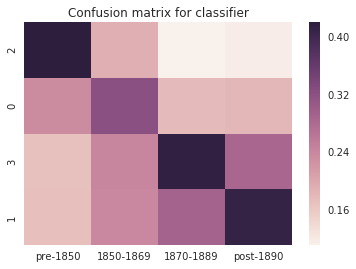

In [25]:
sns.heatmap(date_to_softmax_arr)  # we can see that the closer the dates the more likely things are to cluster
plt.title("Confusion matrix for classifier")

In [16]:
# heatmap it, rank neurons from low->high to high->low
date_to_pool3_arr = {}
for era in date_to_softmax_scores:
    date_to_pool3_arr[era] = pd.DataFrame.from_dict(date_to_pool3_scores[era]).mean(axis=1)
date_to_pool3_arr = pd.DataFrame.from_dict(date_to_pool3_arr)
date_to_pool3_arr = date_to_pool3_arr[labels_sorted]

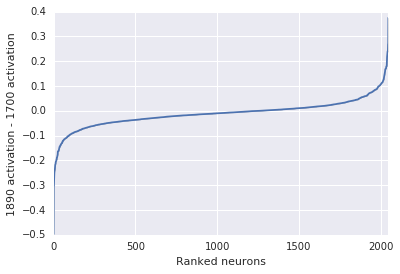

In [17]:
diff = date_to_pool3_arr["post-1890"] - date_to_pool3_arr["pre-1850"]
diff.sort_values(inplace=True)
sns.tsplot(diff)
plt.xlabel("Ranked neurons")
plt.ylabel("1890 activation - 1700 activation")

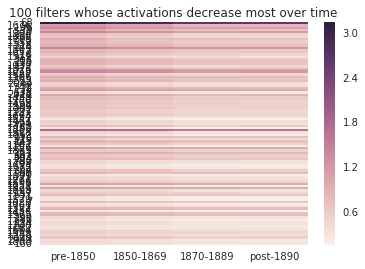

In [18]:
sns.heatmap(date_to_pool3_arr.iloc[diff.index[:100]])
plt.title("100 filters whose activations decrease most over time")

In [21]:
date_to_pool3_arr.iloc[diff.index[:5]]

,pre-1850,1850-1869,1870-1889,post-1890
68,3.164701,2.926382,2.689461,2.667407
1676,1.177736,1.054913,0.815425,0.872043
195,1.391934,1.204870,1.090686,1.089913
79,0.981793,0.794908,0.718366,0.702044
536,1.423544,1.295714,1.087161,1.158399


In [ ]:
## what do these neurons represent?

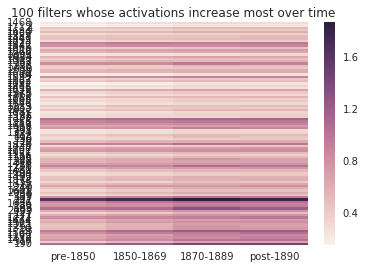

In [19]:
sns.heatmap(date_to_pool3_arr.iloc[diff.index[-100:]])
plt.title("100 filters whose activations increase most over time")

In [22]:
date_to_pool3_arr.iloc[diff.index[-5:]]

,pre-1850,1850-1869,1870-1889,post-1890
1163,0.631798,0.702469,0.891572,0.872752
1232,0.663438,0.771908,0.847568,0.904570
1436,0.773822,0.872257,1.018902,1.041587
317,0.397013,0.541140,0.676417,0.669391
190,1.082369,1.235666,1.418352,1.457642


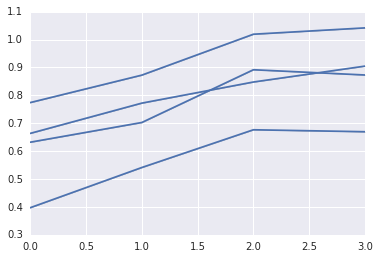

In [20]:
# another way to look at trends

sns.tsplot(date_to_pool3_arr.iloc[diff.index[-5:]].iloc[0])
sns.tsplot(date_to_pool3_arr.iloc[diff.index[-5:]].iloc[1])
sns.tsplot(date_to_pool3_arr.iloc[diff.index[-5:]].iloc[2])
sns.tsplot(date_to_pool3_arr.iloc[diff.index[-5:]].iloc[3])

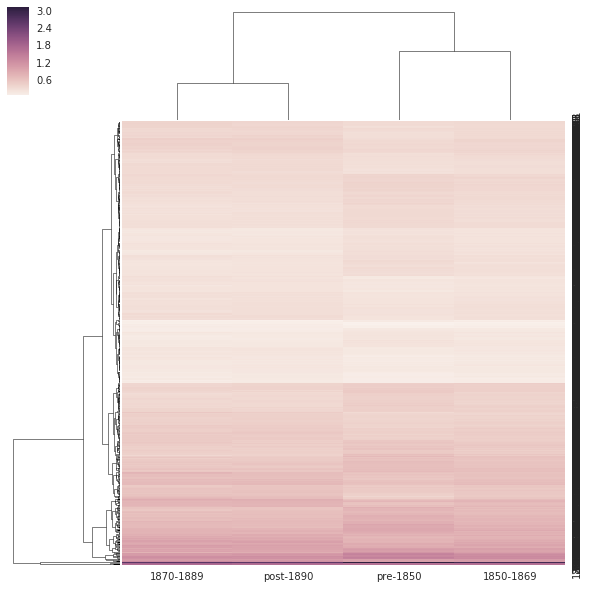

In [34]:
# can do clustering so that we can see which neurons are most activated for each era
date_to_pool3_arr_sig = pd.concat((date_to_pool3_arr.iloc[diff.index[-300:]], date_to_pool3_arr.iloc[diff.index[:300]]))
sns.clustermap(date_to_pool3_arr_sig)

## Layer 0

In [26]:
# what other layers are there that we could look at?

# reconstruct date_to_images
date_to_images = {}
for era in date_to_softmax_scores:
    date_to_images[era] = {}
    for img in date_to_softmax_scores[era]:
        idx = image_to_idx[img]
        date_to_images[era][img] = idx

In [27]:
date_to_conv0_scores = {}
conv0_tensor = sess.graph.get_tensor_by_name('conv:0')

for era in date_to_images:
    print era
    date_to_conv0_scores[era] = {}

    for img in date_to_images[era]:
        idx = date_to_images[era][img]
        
        chk = idx/5000
        chunk = "Chunk" + str(chk)
        i = idx % 5000
        if chunk not in image_hdf5: continue

        a = [to_rgb(image_hdf5[chunk][i][:,:,0])]
        predictions = sess.run(conv0_tensor, {'ExpandDims:0': a})
        date_to_conv0_scores[era][img] = predictions.sum(axis=(0,1,2))

pickle.dump(date_to_conv0_scores, open("/data/maps_by_date/conv0_scores.pkl", 'w'))

pre-1850
1870-1889
1850-1869
post-1890


In [122]:
conv0_tensor.eval(session=sess).shape

(1, 149, 149, 32)

In [128]:
date_to_conv0_scores['1870-1889']['000359422_0_000208_4_'].shape

(32,)

In [29]:
# heatmap it, rank neurons from low->high to high->low
date_to_conv0_arr = {}
for era in date_to_conv0_scores:
    date_to_conv0_arr[era] = pd.DataFrame.from_dict(date_to_conv0_scores[era]).mean(axis=1)
date_to_conv0_arr = pd.DataFrame.from_dict(date_to_conv0_arr)
date_to_conv0_arr = date_to_conv0_arr[labels_sorted]

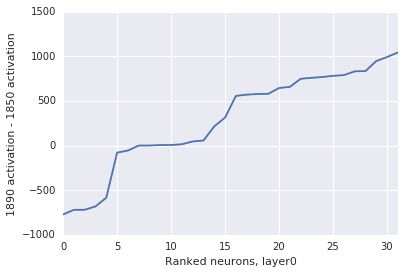

In [31]:
diff_conv0 = date_to_conv0_arr["post-1890"] - date_to_conv0_arr["pre-1850"]
diff_conv0.sort_values(inplace=True)
sns.tsplot(diff_conv0)
plt.xlabel("Ranked neurons, layer0")
plt.ylabel("1890 activation - 1850 activation")

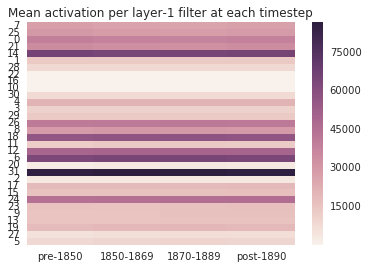

In [32]:
sns.heatmap(date_to_conv0_arr.ix[diff_conv0.index])
plt.title("Mean activation per layer-1 filter at each timestep")

## Conv 4

In [33]:
date_to_conv4_scores = {}
conv4_tensor = sess.graph.get_tensor_by_name('conv_4:0')

for era in date_to_images:
    print era
    date_to_conv4_scores[era] = {}

    for img in date_to_images[era]:
        idx = date_to_images[era][img]
        
        chk = idx/5000
        chunk = "Chunk" + str(chk)
        i = idx % 5000
        if chunk not in image_hdf5: continue

        a = [to_rgb(image_hdf5[chunk][i][:,:,0])]
        predictions = sess.run(conv4_tensor, {'ExpandDims:0': a})
        date_to_conv4_scores[era][img] = predictions.sum(axis=(0,1,2))

pickle.dump(date_to_conv4_scores, open("/data/maps_by_date/conv4_scores.pkl", 'w'))

pre-1850
1870-1889
1850-1869
post-1890


In [38]:
# heatmap it, rank neurons from low->high to high->low
date_to_conv4_arr = {}
for era in date_to_conv0_scores:
    date_to_conv4_arr[era] = pd.DataFrame.from_dict(date_to_conv4_scores[era]).mean(axis=1)
date_to_conv4_arr = pd.DataFrame.from_dict(date_to_conv4_arr)
date_to_conv4_arr = date_to_conv4_arr[labels_sorted]

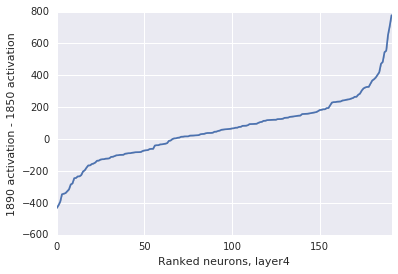

In [40]:
diff_conv4 = date_to_conv4_arr["post-1890"] - date_to_conv4_arr["pre-1850"]
diff_conv4.sort_values(inplace=True)
sns.tsplot(diff_conv4)
plt.xlabel("Ranked neurons, layer4")
plt.ylabel("1890 activation - 1850 activation")

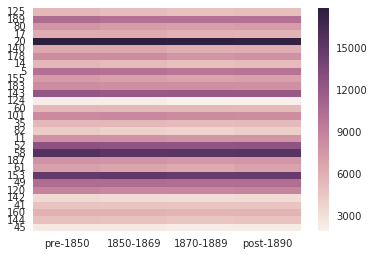

In [41]:
sns.heatmap(date_to_conv4_arr.ix[diff_conv4.index[:30]])

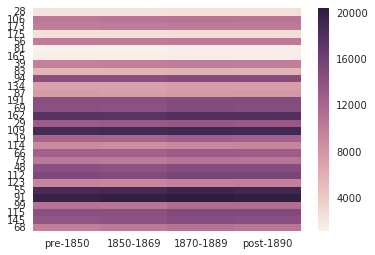

In [42]:
sns.heatmap(date_to_conv4_arr.ix[diff_conv4.index[-30:]])

## Mixed 5

In [43]:
date_to_mix5_scores = {}
mix5_tensor = sess.graph.get_tensor_by_name('mixed_5/join:0')

for era in date_to_images:
    print era
    date_to_mix5_scores[era] = {}

    for img in date_to_images[era]:
        idx = date_to_images[era][img]
        
        chk = idx/5000
        chunk = "Chunk" + str(chk)
        i = idx % 5000
        if chunk not in image_hdf5: continue

        a = [to_rgb(image_hdf5[chunk][i][:,:,0])]
        predictions = sess.run(mix5_tensor, {'ExpandDims:0': a})
        date_to_mix5_scores[era][img] = predictions.sum(axis=(0,1,2))

pickle.dump(date_to_mix5_scores, open("/data/decorations_by_date/mix5_scores.pkl", 'w'))

pre-1850
1870-1889
1850-1869
post-1890


In [44]:
# heatmap it, rank neurons from low->high to high->low
date_to_mix5_arr = {}
for era in date_to_conv0_scores:
    date_to_mix5_arr[era] = pd.DataFrame.from_dict(date_to_mix5_scores[era]).mean(axis=1)
date_to_mix5_arr = pd.DataFrame.from_dict(date_to_mix5_arr)
date_to_mix5_arr = date_to_mix5_arr[labels_sorted]

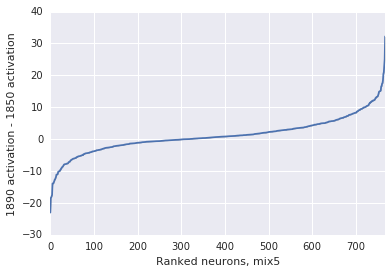

In [48]:
diff_mix5 = date_to_mix5_arr["post-1890"] - date_to_mix5_arr["pre-1850"]
diff_mix5.sort_values(inplace=True)
sns.tsplot(diff_mix5)
plt.xlabel("Ranked neurons, mix5")
plt.ylabel("1890 activation - 1850 activation")

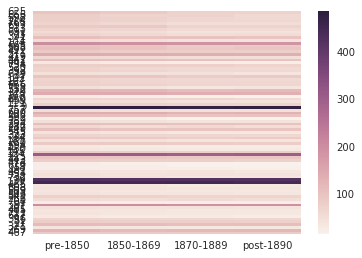

In [49]:
sns.heatmap(date_to_mix5_arr.ix[diff_mix5.index[:80]])

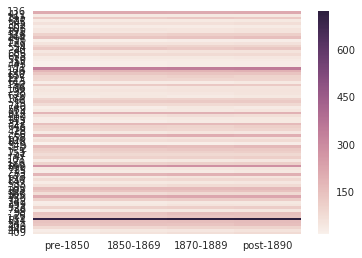

In [50]:
sns.heatmap(date_to_mix5_arr.ix[diff_mix5.index[-80:]])